## Calculate k-mer enrichment in PAR-CLIP binding sites

In [1]:
import numpy as np
import os
import pandas as pd
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import pickle

#### set script parameters

In [2]:
home_dir = '/home/salma/Coding/scratch/'
w = 8  #the width used for fasta file generation
pipeline_dir = os.path.join(home_dir, 'pipeline')
plotting_dir = os.path.join(home_dir, 'plots/kmer_counts')

xxmotif_file = 'motif/xxmotif_xxmotif_start0_stop5000_width%d_sort_occupancy.fa' % w  #fasta files generated by xxmotif tool
k = 4  #k in k-mer

#choose factors to analyse
pathways_of_interest = ['Surveillance', 'Deadenylation', 'Decapping', 'Xrn1', 'Exosome', 'NMD']

In [3]:
#load data list
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary.txt'), header=None)

data_summary.columns=['factor','pathway','group']
data_summary.index = data_summary.factor
factors = data_summary.factor

factors_of_interest = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']

In [4]:
def fasta_parser(filename):
    with open(filename, 'r') as f:
        s = f.readlines()
    return list(map(str.rstrip, s[1::2]))

In [5]:
def count_kmers_plot(pipeline_dir, k):
    
    counts_all = {} #store counts for each factor as a df in a dictionary
    enrichment_all ={}
    
    for factor in factors_of_interest:    
        
        fasta_file = os.path.join(pipeline_dir, factor, 'postprocess', xxmotif_file) 
        seqs = fasta_parser(fasta_file)
        
        bases=['A','T','G','C']
        kmers = [''.join(p) for p in itertools.product(bases, repeat=k)]
        # Calculate how many kmers of length k there are
        num_kmers = len(seqs[0]) - k + 1
        counts = pd.DataFrame(0, columns=list(range(num_kmers)), index=kmers)


        # Loop over the kmer start positions
        for seq in seqs:
            for i in range(num_kmers):
                # Slice the string to get the kmer
                kmer = seq[i:i+k]
                # Increment the count for this kmer
                counts.loc[kmer, i] += 1

        #expectation = np.power(0.19,2)*np.power(0.31,2)*len(seqs) #if not limited by 'T' --> NNNN
        #expectation_T = expectation*0.31 #if limited by 'T' --> NNNT
        expectation = {'T':0.31, 'A':0.31, 'C':0.19, 'G':0.19}
        
        mid = int((len(seqs[0])-1)/2)
        correction = pd.DataFrame(0, columns=list(range(num_kmers)), index=kmers)
        for inx in correction.index:
            for col in list(range(num_kmers)):
                correction.loc[inx, col] = np.prod([expectation[base] for base in inx] + [len(seqs)])
                if (mid-col>=0 and mid-col<k):
                    if inx[mid-col]=='T':
                        correction.loc[inx, col] = np.prod([expectation[base] for base in inx] + [len(seqs)] + [1/expectation['T']])
                    else:
                        correction.loc[inx, col] = np.nan
                        
        enrichment = (counts+1)/correction

        top5 = list(enrichment.sum(axis = 1).sort_values().index[-5:][::-1])
        low3 = list(enrichment.sum(axis = 1).sort_values().index[:3])

        enrichment_plot = enrichment.loc[top5+low3,:]

        labels = [x-int((len(seqs[0])-1)/2) for x in list(range(len(enrichment_plot.columns)))]
        labels[int((len(seqs[0])-1)/2)] = 'U'
        enrichment_plot.columns = labels

        enr_log_plot = pd.DataFrame([np.log2(x) for x in enrichment_plot.values.tolist()], columns=list(enrichment_plot.columns.values))
        enr_log_plot.index = enrichment_plot.index
        
        counts_all[factor] = enr_log_plot
        
        enrichment_log = pd.DataFrame([np.log2(x) for x in enrichment.values.tolist()], columns=list(enrichment.columns.values))
        enrichment_log.index = enrichment.index
        
        enrichment_all[factor] = enrichment_log
        
    return counts_all, enrichment_all

In [6]:
#function: SHIFT COLORMAP
#source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [7]:
counts_all, enrichment_all = count_kmers_plot(pipeline_dir, k)

In [8]:
colorsList = ['xkcd:lightblue','white']
cmap_blue = matplotlib.colors.LinearSegmentedColormap.from_list('costom', colorsList)

colors1 = plt.cm.Blues_r(np.linspace(0, 1, 200))
colors2 = plt.cm.OrRd(np.linspace(0., 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1[-128:], colors2))
CustomCmap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

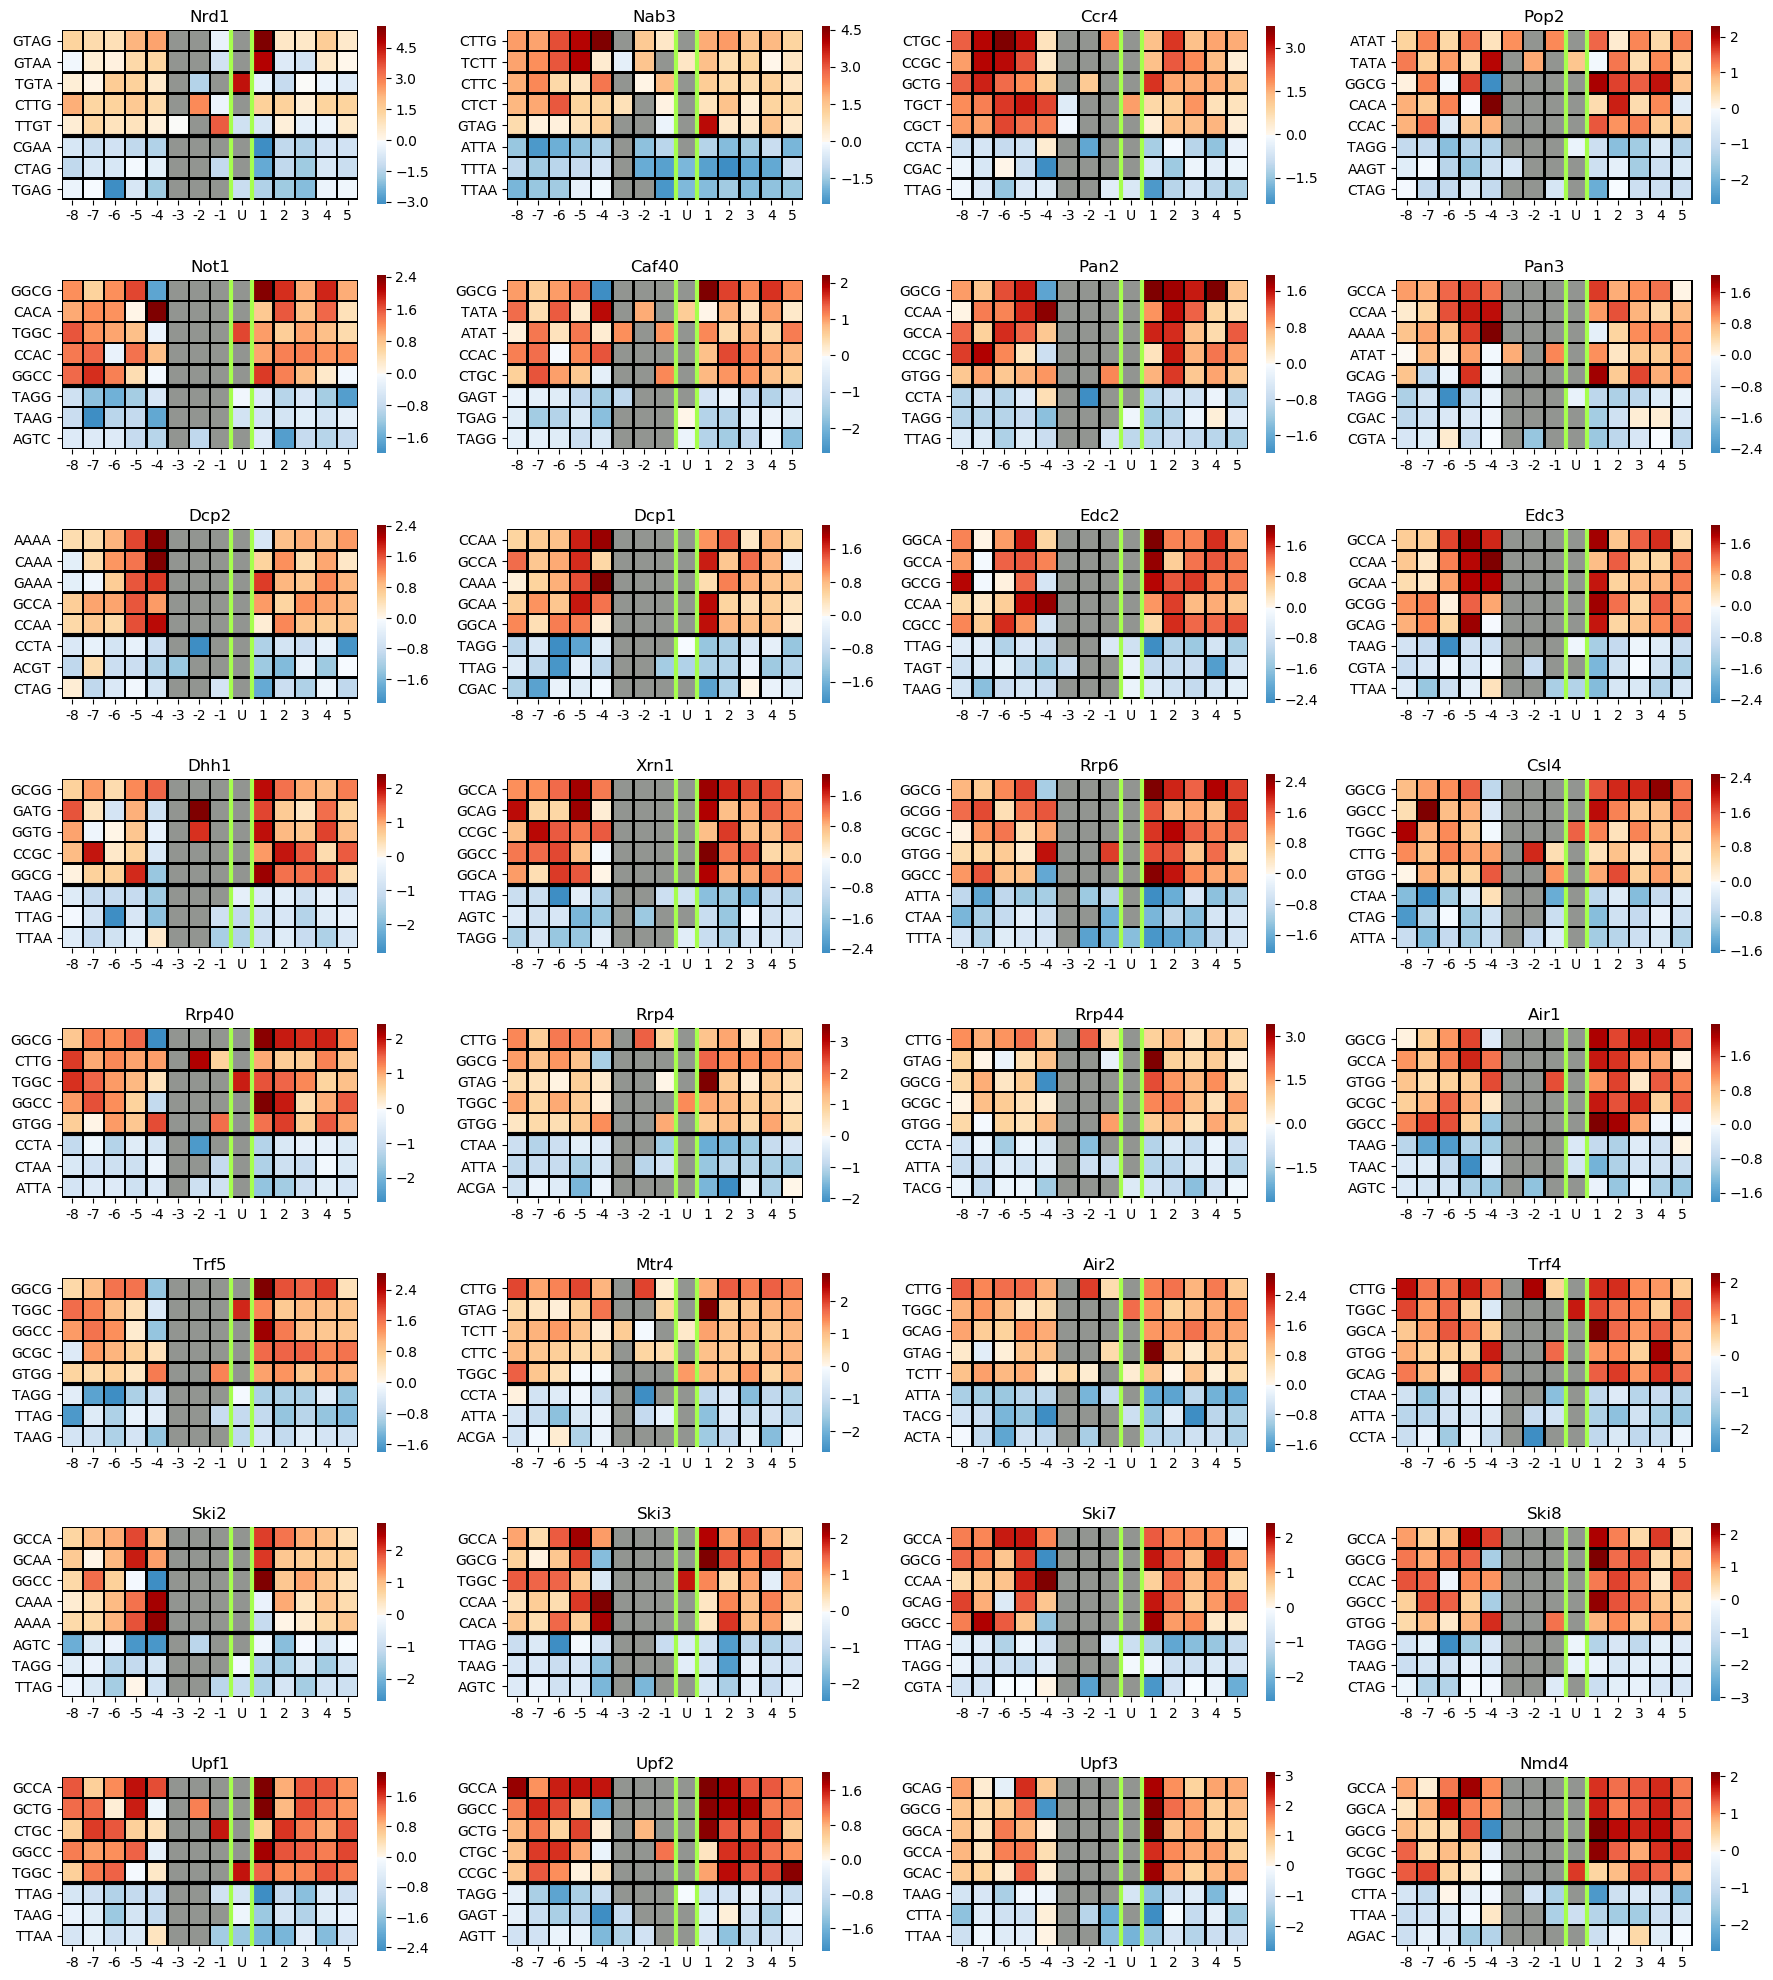

In [9]:
plt.style.use('default')
plt.figure(figsize=(22,25))
#plt.suptitle("Factor occupancy for transcripts sorted by length", fontsize = 14, y = 0.93)

for i, factor in enumerate(factors_of_interest):
    dfmax =  np.max(counts_all[factor].max())
    dfmin =  np.min(counts_all[factor].min())

    orig_cmap = CustomCmap
    newcmap = shiftedColorMap(orig_cmap, midpoint=1 - dfmax/(dfmax + abs(dfmin)), name='shifted')
    newcmap.set_bad(color='xkcd:grey')
    
    ax1 = plt.subplot(8,4,i+1)
    sns.heatmap(counts_all[factor], cmap=newcmap, linewidths=1, linecolor='black', square=True, ax=ax1)
    if factor=='Rrp4-':
        ax1.set_title('Rrp4')
    else:
        ax1.set_title(factor)
    plt.axvline(w, color='#a6ff4d', linewidth=3)
    plt.axvline(w+1, color='#a6ff4d', linewidth=3)
    plt.axhline(5 , color='black', linewidth=3)
    
    plt.subplots_adjust(hspace = 0.4)
plt.savefig(os.path.join(plotting_dir,'top_kmers_width%d.pdf' % w), bbox_inches='tight')

In [11]:
# Saving the objects:
with open(os.path.join(home_dir, 'analysis', '%smer_counts_all.pkl'%k), 'wb') as f: 
    pickle.dump([counts_all, enrichment_all], f)